In [1]:
from pulse2percept.models import AxonMapModel, BiphasicAxonMapModel, BiphasicAxonMapSpatial, Model, AxonMapSpatial
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusII, ElectrodeArray

import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["JAX_LOG_COMPILES"] = "True"
import jax.numpy as jnp
import jax
from jax import jit, partial, vmap
jax.devices()

[GpuDevice(id=0, process_index=0)]

## Where the magic happens (Jax predict_percept())

In [2]:
# NEW jax copy

def predict_one_segment(axon_segment, brights, sizes, streaks, x, y, rho, axlambda):
    d2_el = (axon_segment[0, None] - x)**2 + (axon_segment[1, None] - y)**2
    intensity = brights * jnp.exp(-d2_el / (2. * rho**2 * sizes)) * (axon_segment[2] ** 1./streaks)
    return jnp.sum(intensity)


# also vmap over simulated points
def predict_one_point(axon, brights, sizes, streaks, x, y, rho, axlambda):
#     d2_el = (axon[:, 0, None] - x)**2 + (axon[:, 1, None] - y)**2
#     intensities = brights * np.exp(-d2_el / (2. * rho**2 * sizes)) * (axon[:, 2, None] ** (1./streaks))
#     return jnp.max(np.sum(intensities, axis=1))
    intensities = jit(vmap(predict_one_segment, in_axes=[0, None, None, None, None, None, None, None]), static_argnums=[6,7])(axon, brights, sizes, streaks, x, y, rho, axlambda)
    return jnp.max(intensities)
def gpu_biphasic_axon_map(params, # Per ACTIVE electrode, (amp, freq, pdur, x, y)
                          axon_segments, rho, axlambda, thresh_percept):
    deg2rad = 3.14159265358979323846 / 180.0

#     n_space = len(axon_segments)

    min_size = 10**2 / rho**2
    min_streak = 10**2 / axlambda **2

    # First get contributions from F, G, H per electrode
    scaled_amps = params[0] / (0.8825 + 0.27*params[2])
    brights = 1.84*scaled_amps + 0.2*params[1] + 2.0986
    sizes = jnp.maximum(1.081*scaled_amps - 0.3533764, min_size)
    streaks = jnp.maximum(1.56 - 0.54 * params[2] ** 0.21, min_streak)

    # axon_segments is (n_space, axon_length, 3), x and y are (n_elec)
    d2_el = (axon_segments[:, :, 0, None] - params[3])**2 + (axon_segments[:, :, 1, None] - params[4])**2
    # (n_space, axon_length, n_elecs)
    
    #                       (n_elecs) (n_space, axon_length, n_elecs)            (n_space, axon_length, n_elecs) 
    electrode_intensities = brights * jnp.exp(-d2_el / ( 2. * rho**2. * sizes)) * (axon_segments[:, :, 2, None] ** (1. / streaks))
    # (n_space, axon_length, n_elecs)
    
#     axon_intensities = 
    # (n_space, n_elecs)
    I = jnp.max(jnp.sum(electrode_intensities, axis=2), axis=1)
    
    
#     I = jit(vmap(predict_one_point, in_axes=[0, None, None, None, None, None, None, None]), static_argnums=[6, 7])(axon_segments, brights, sizes, streaks, params[3], params[4], rho, axlambda)
#     I = (I > thresh_percept) * I
    return I



## Try again but this time push max operation to the end

In [2]:
# def predict_one_segment(axon_segment, brights, sizes, streaks, x, y, rho, axlambda):
#     d2_el = (axon_segment[0, None] - x)**2 + (axon_segment[1, None] - y)**2
#     intensity = brights * np.exp(-d2_el / (2. * rho**2 * sizes)) * (axon_segment[2] ** 1./streaks)
#     return np.sum(intensity)


# also vmap over simulated points
def predict_one_point(axon, brights, sizes, streaks, x, y, rho, axlambda):
    d2_el = (axon[:, 0, None] - x)**2 + (axon[:, 1, None] - y)**2
    intensities = brights * jnp.exp(-d2_el / (2. * rho**2 * sizes)) * (axon[:, 2, None] ** (1./streaks))
    return jnp.sum(intensities, axis=1)
#     return jit(vmap(predict_one_segment, in_axes=[0, None, None, None, None, None, None, None]), static_argnums=[6,7])(axon, brights, sizes, streaks, x, y, rho, axlambda)

def gpu_biphasic_axon_map(params, # Per ACTIVE electrode, (amp, freq, pdur, x, y)
                          axon_segments, rho, axlambda, thresh_percept):
    deg2rad = 3.14159265358979323846 / 180.0

#     n_space = len(axon_segments)

    min_size = 10**2 / rho**2
    min_streak = 10**2 / axlambda **2

    # First get contributions from F, G, H per electrode
    scaled_amps = params[0] / (0.8825 + 0.27*params[2])
    brights = 1.84*scaled_amps + 0.2*params[1] + 2.0986
    sizes = jnp.maximum(1.081*scaled_amps - 0.3533764, min_size)
    streaks = jnp.maximum(1.56 - 0.54 * params[2] ** 0.21, min_streak)

#     # axon_segments is (n_space, axon_length, 3), x and y are (n_elec)
#     d2_el = (axon_segments[:, :, 0, None] - params[3])**2 + (axon_segments[:, :, 1, None] - params[4])**2
#     # (n_space, axon_length, n_elecs)
    
#     #                       (n_elecs) (n_space, axon_length, n_elecs)            (n_space, axon_length, n_elecs) 
#     electrode_intensities = brights * jnp.exp(-d2_el / ( 2. * rho**2. * sizes)) * (axon_segments[:, :, 2, None] ** (1. / streaks))
#     # (n_space, axon_length, n_elecs)
    
# #     axon_intensities = 
#     # (n_space, n_elecs)
#     I = np.sum(electrode_intensities, axis=2)
    
    
    
    
    I = jnp.max(jit(vmap(predict_one_point, in_axes=[0, None, None, None, None, None, None, None]), static_argnums=[6, 7])(axon_segments, brights, sizes, streaks, params[3], params[4], rho, axlambda), axis=1)
#     I = (I > thresh_percept) * I
    return I


#### Build model here in new spatial subclass, wrapped in BiphasicAxonMapGPU

In [3]:
import time
from copy import deepcopy
from pulse2percept.percepts import Percept
class BiphasicAxonMapGPUSpatial(AxonMapSpatial):
    def __init__(self, **params):
        super(BiphasicAxonMapGPUSpatial, self).__init__(**params)

    def _predict_spatial(self, earray, stim):
#         start = time.time()
        assert isinstance(earray, ElectrodeArray)
        assert isinstance(stim, Stimulus)

        # get relevant stimulus properties
        amps = np.array([stim.metadata['electrodes'][str(e)]['metadata']['amp'] for e in stim.electrodes], dtype="float32")
        freqs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['freq'] for e in stim.electrodes], dtype="float32")
        pdurs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['phase_dur'] for e in stim.electrodes], dtype="float32")

        x = np.array([earray[e].x for e in stim.electrodes], dtype=np.float32)
        y = np.array([earray[e].y for e in stim.electrodes], dtype=np.float32)
        
        params = np.vstack([amps, freqs, pdurs, x, y])
#         begin = time.time()
#         print("Setup time: %.3fms" % ((begin - start)*1000))
#         params = jax.device_put(params, jax.devices()[0])
#         ax_contrib = jax.device_put(self.axon_contrib, jax.devices()[0])
#         ax_contrib = self.axon_contrib
#         e1 = time.time()
#         print("Transfer time: %.3fms" % ((e1 - begin)*1000))
        p =  jit(gpu_biphasic_axon_map, static_argnums=[2,3,4,5])(params,
                                     self.axon_contrib,
                                     self.rho, self.axlambda, self.thresh_percept)
#         end = time.time()
#         print("Jax time: {} ms on sample {}".format((end - begin) * 1000, stim.shape))

        return p

    def _build(self):
        super(BiphasicAxonMapGPUSpatial, self)._build()
        self.axon_contrib = jax.device_put(self.axon_contrib, jax.devices()[0])
        
        



class BiphasicAxonMapGPU(Model):
    def __init__(self, **params):
        super(BiphasicAxonMapGPU, self).__init__(spatial=BiphasicAxonMapGPUSpatial(), temporal=None, **params)

    def predict_percept(self, implant, t_percept=None):
#         start = time.time()
        # Make sure stimulus is a BiphasicPulseTrain:
        if not isinstance(implant.stim, BiphasicPulseTrain):
            # Could still be a stimulus where each electrode has a biphasic pulse train
            for ele, params in implant.stim.metadata['electrodes'].items():
                if params['type'] != BiphasicPulseTrain or params['metadata']['delay_dur'] != 0: 
                    raise TypeError("All stimuli must be BiphasicPulseTrains with no delay dur (Failing electrode: %s)" % (ele)) 
        
#         return super(BiphasicAxonMapGPU, self).predict_percept(implant, t_percept=t_percept)

        if not self.is_built:
            raise NotBuiltError("Yout must call ``build`` first.")
        if not isinstance(implant, ProsthesisSystem):
            raise TypeError(("'implant' must be a ProsthesisSystem object, "
                             "not %s.") % type(implant))

        # Calculate the Stimulus at requested time points:

        stim = Stimulus(implant.stim) # make sure stimulus is in proper format

#         e4 = time.time()
#         print("Stim restructuring and checks: %.3fms" % ((e4 - start) * 1000))
        
        resp = self._predict_spatial(implant.earray, stim)
#         e5 = time.time()
#         print("predict_spatial: %.3fms" % ((e5 - e4) * 1000))
        p = Percept(resp.reshape(list(self.grid.x.shape) + [-1]),
                       space=self.grid, time=None,
                       metadata={'stim': stim.metadata})
#         e6 = time.time()
#         print("Percept Construction: %.3fms" % ((e6 - e5) * 1000))
        return p

    def predict_percept_batched(self, implant, stim_list, t_percept=None):
        start = time.time()
        for stim in stim_list:
            if not isinstance(stim, BiphasicPulseTrain):
                # Could still be a stimulus where each electrode has a biphasic pulse train
                for ele, params in stim.metadata['electrodes'].items():
                    if params['type'] != BiphasicPulseTrain or params['metadata']['delay_dur'] != 0: 
                        raise TypeError("All stimuli must be BiphasicPulseTrains with no delay dur (Failing electrode: %s)" % (ele)) 
        
        if not self.is_built:
            raise NotBuiltError("You must call ``build`` first.")
        if not isinstance(implant, ProsthesisSystem):
            raise TypeError(("'implant' must be a ProsthesisSystem object, "
                             "not %s.") % type(implant))
        
        batch = []
        for stim in stim_list:   
            amps = np.array([stim.metadata['electrodes'][str(e)]['metadata']['amp'] for e in stim.electrodes], dtype="float32")
            freqs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['freq'] for e in stim.electrodes], dtype="float32")
            pdurs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['phase_dur'] for e in stim.electrodes], dtype="float32")
            x = np.array([implant.earray[e].x for e in stim.electrodes], dtype=np.float32)
            y = np.array([implant.earray[e].y for e in stim.electrodes], dtype=np.float32)

            batch.append(np.vstack([amps, freqs, pdurs, x, y]))
        
        batch = np.array(batch) 
        e1 = time.time()
        print("Setup: %.3fms" % ((e1 - start) * 1000))
#         print(batch.shape)
        start = time.time()
#         print("Transfer: %.3fms" % ((start - e1) * 1000))
        resps = jit(vmap(gpu_biphasic_axon_map, in_axes=[0, None, None, None, None]), static_argnums=[2,3,4])(batch, self.axon_contrib, self.rho, self.axlambda, self.thresh_percept).block_until_ready()
        end = time.time()
        print("Jax time: %.3f ms, %.3f ms per sample" % (float(end - start) * 1000, float((end - start) * 1000 / len(stim_list))))

    

In [4]:
model = BiphasicAxonMapGPU(axon_length = 0.5, axlambda=800)
model.build()
implant = ArgusII()
stim = Stimulus({"A2" : BiphasicPulseTrain(20, 1, 0.45), "A10" : BiphasicPulseTrain(30, 1, 0.45)})
implant.stim = stim

model_orig = BiphasicAxonMapModel(axlambda=800)
model_orig.build()
print()

In [36]:
stim = Stimulus({ "A10" : BiphasicPulseTrain(30, 1, 0.45)})
implant.stim = stim

In [84]:
stim = Stimulus({"A2" : BiphasicPulseTrain(20, 1, 0.45), "A10" : BiphasicPulseTrain(30, 1, 0.45), "A4" : BiphasicPulseTrain(20, 1, 0.45), "A7" : BiphasicPulseTrain(30, 1, 0.45)})
implant.stim = stim

1.7504692077636719


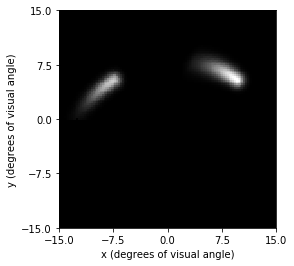

In [6]:
start = time.time()
percept = model.predict_percept(implant)
print((time.time() - start)*1000)
percept.plot()

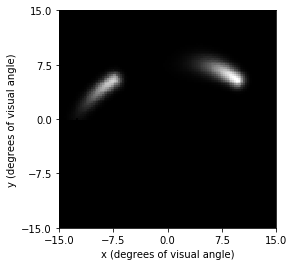

In [8]:
p1 = model_orig.predict_percept(implant)
p1.plot()

In [9]:
np.max(p1.data - percept.data)

0.99732065

In [10]:
np.mean(p1.data - percept.data)

0.020292625

In [116]:
percept.get_brightest_frame().max()

9.835198

In [117]:
p1.get_brightest_frame().max()

10.825558

## Timing

In [1]:
import time
import random
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain

batch = None
batched_size = None
def rand_stim(implant, n_electrodes=1):
    maxamp = 15
    maxfreq = 200
    elecs = set()
    while len(elecs) < n_electrodes:
        # add another electrode
        elecs.add(random.choice(list(implant.electrode_names)))
    stim = {}
    for elec in elecs:
        amp = random.random() * maxamp
        freq = random.random() * maxfreq
        pdur = random.expovariate(1)
        while pdur > 1000 / freq / 2 or pdur < 0.01 or pdur > 100:
            pdur = random.expovariate(1)
        stim[elec] = BiphasicPulseTrain(freq, amp, pdur, stim_dur=1000)
    stimulus = Stimulus(stim)
    return stimulus

def time_constant(model, implant, n_elecs=1, n_samples=10, stim_func=rand_stim, verbose=True):
    total_time = 0
    for i in range(n_samples):
        try:
            stim = stim_func(implant, n_electrodes=n_elecs)
            implant.stim = stim
            start = time.time()
            percept = model.predict_percept(implant)
            end = time.time()
#             print((end - start) * 1000)
            total_time += end - start
        except Exception as e:
            print(e)
            continue
    if verbose:
        print("Average prediction time (%d electrodes): %.2fms" % (n_elecs, total_time / n_samples * 1000))
        print("Average prediction time per electrode: %.2fms" % (total_time / n_samples * 1000 / n_elecs))
    return total_time / n_samples * 1000

def time_batch(model, implant, n_elecs=1, batch_size=256, stim_func=rand_stim, verbose=True):
    global batch, batched_size
    if batch is None or batched_size != batch_size: # use precomputed batch if possible
        stim_list = []
        for i in range(batch_size):
            try:
                stim_list.append(stim_func(implant, n_electrodes=n_elecs))
            except Exception as e:
                i -= 1
                print(e)
                continue
        batch = stim_list
        batched_size = batch_size
    else:
        stim_list = batch
    
    print("predicting percepts")
    start = time.time()
    model.predict_percept_batched(implant, stim_list)
    end = time.time()
    total_time = end - start
    print("Average prediction time (%d electrodes): %.2fms" % (n_elecs, total_time / batch_size * 1000))
    print("Total batch time: %.3fs" % (end - start))
    return (end - start) / batch_size * 1000

In [13]:
# model = BiphasicAxonMapGPU(axon_length=0.5)
# model.build()
# implant = ArgusII(rot=45)
time_constant(model, implant, n_elecs=1, n_samples=50)
time_constant(model, implant, n_elecs=15, n_samples=50)

Average prediction time (1 electrodes): 0.56ms
Average prediction time per electrode: 0.56ms
Average prediction time (15 electrodes): 0.88ms
Average prediction time per electrode: 0.06ms


0.8769369125366211

In [17]:
# model = BiphasicAxonMapGPU(axon_length=0.5)
# model.build()
# implant = ArgusII(rot=45)
time_batch(model, implant, n_elecs=15, batch_size=256)

predicting percepts
Setup: 26.215ms
Jax time: 139.146 ms, 0.548 ms per sample
Average prediction time (15 electrodes): 0.65ms
Total batch time: 0.166s


0.6470028311014175

'str' object cannot be interpreted as an integer
'str' object cannot be interpreted as an integer
'str' object cannot be interpreted as an integer
'str' object cannot be interpreted as an integer


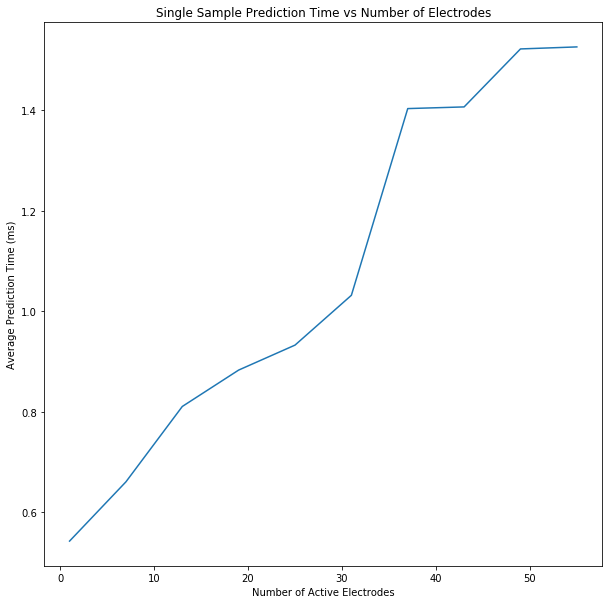

In [19]:
import matplotlib.pyplot as plt
n_elecs = np.arange(1, 60, 6)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
times = []
model = BiphasicAxonMapGPU(axon_length=0.5)
model.build()
implant = ArgusII(rot=45)
time_constant(model, implant, n_samples=20, n_elecs=1, verbose=False)
for n_elec in n_elecs:
    times.append(time_constant(model, implant, n_samples=20, n_elecs=n_elec, verbose=False))
ax.plot(n_elecs, times)
ax.set_xlabel("Number of Active Electrodes")
ax.set_ylabel("Average Prediction Time (ms)")
ax.set_title("Single Sample Prediction Time vs Number of Electrodes")
    
fig.show()

predicting percepts
Setup: 22.231ms
Jax time: 146.331 ms, 0.576 ms per sample
Average prediction time (55 electrodes): 0.66ms
Total batch time: 0.169s
predicting percepts
Setup: 21.135ms
Jax time: 134.459 ms, 0.529 ms per sample
Average prediction time (1 electrodes): 0.61ms
Total batch time: 0.156s
predicting percepts
Setup: 21.260ms
Jax time: 135.989 ms, 0.535 ms per sample
Average prediction time (6 electrodes): 0.61ms
Total batch time: 0.157s
predicting percepts
Setup: 22.129ms
Jax time: 134.194 ms, 0.528 ms per sample
Average prediction time (11 electrodes): 0.61ms
Total batch time: 0.156s
predicting percepts
Setup: 21.993ms
Jax time: 134.743 ms, 0.530 ms per sample
Average prediction time (16 electrodes): 0.61ms
Total batch time: 0.157s
predicting percepts
Setup: 21.407ms
Jax time: 135.691 ms, 0.534 ms per sample
Average prediction time (21 electrodes): 0.61ms
Total batch time: 0.157s
predicting percepts
Setup: 21.801ms
Jax time: 133.465 ms, 0.525 ms per sample
Average prediction

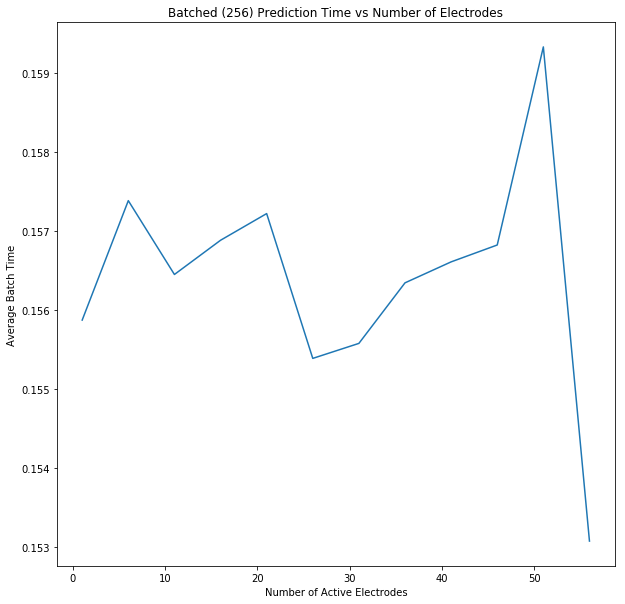

In [20]:
import matplotlib.pyplot as plt
n_elecs = np.arange(1, 60, 5)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
times = []
model = BiphasicAxonMapGPU(axon_length=0.5)
model.build()
implant = ArgusII(rot=45)
time_batch(model, implant, batch_size=256, n_elecs=n_elec, verbose=False)
for n_elec in n_elecs:
    times.append(256 / 1000 * time_batch(model, implant, batch_size=256, n_elecs=n_elec, verbose=False))
ax.plot(n_elecs, times)
ax.set_xlabel("Number of Active Electrodes")
ax.set_ylabel("Average Batch Time")
ax.set_title("Batched (256) Prediction Time vs Number of Electrodes")
    
fig.show()

predicting percepts
Setup + transfer: 450.588ms
Jax time: 5.687 s, 22.304 ms per sample
Average prediction time (1 electrodes): 24.16ms
Total batch time: 6.184s
predicting percepts
Setup + transfer: 452.582ms
Jax time: 5.801 s, 22.748 ms per sample
Average prediction time (6 electrodes): 24.61ms
Total batch time: 6.301s
predicting percepts
Setup + transfer: 453.048ms
Jax time: 5.720 s, 22.431 ms per sample
Average prediction time (11 electrodes): 24.29ms
Total batch time: 6.219s
predicting percepts
Setup + transfer: 445.938ms
Jax time: 5.699 s, 22.349 ms per sample
Average prediction time (16 electrodes): 24.18ms
Total batch time: 6.191s
predicting percepts
Setup + transfer: 448.912ms
Jax time: 5.729 s, 22.468 ms per sample
Average prediction time (21 electrodes): 24.32ms
Total batch time: 6.225s
predicting percepts
Setup + transfer: 451.864ms
Jax time: 5.694 s, 22.331 ms per sample
Average prediction time (26 electrodes): 24.19ms
Total batch time: 6.192s
predicting percepts
Setup + tr

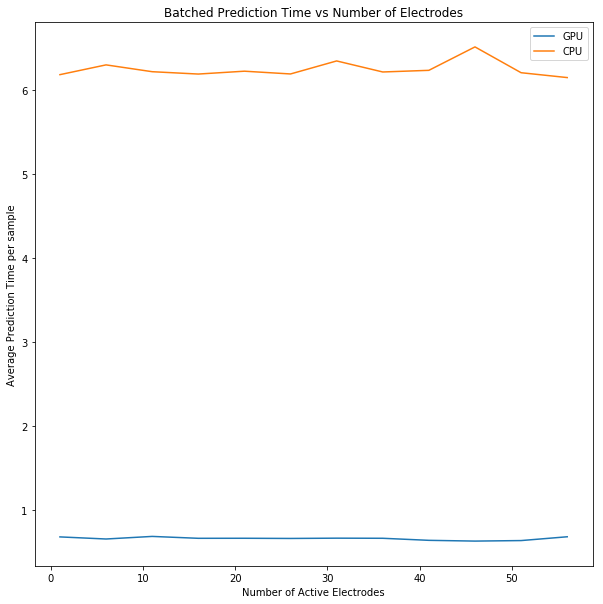

In [97]:
import matplotlib.pyplot as plt
n_elecs = np.arange(1, 60, 5)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
times1 = []
model = BiphasicAxonMapGPU(axon_length=0.5)
model.build()
implant = ArgusII(rot=45)
for n_elec in n_elecs:
    times1.append(256 / 1000 * time_batch(model, implant, batch_size=256, n_elecs=n_elec, verbose=False))
ax.plot(n_elecs, times, label="GPU")
ax.plot(n_elecs, times1, label="CPU")
ax.set_xlabel("Number of Active Electrodes")
ax.set_ylabel("Average Prediction Time per sample")
ax.set_title("Batched Prediction Time vs Number of Electrodes")
ax.legend()
    
fig.show()

# Axon Map

In [1]:
from pulse2percept.models import AxonMapModel, BiphasicAxonMapModel, BiphasicAxonMapSpatial, Model, AxonMapSpatial
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusII, ElectrodeArray

import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import jax.numpy as jnp
import jax
from jax import jit, partial, vmap
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [2]:
def predict_one_space_time(amp, d2_el, sensitivities, rho):
    #             (n_elec) (n_segments, n_elec) (n_segments) -> (n_segments, n_elec) -> (n_segments)
    return jnp.sum(amp * jnp.exp(-d2_el / (2. * rho**2)) * sensitivities[:, None], axis=1)


def predict_one_space(amps, xs, ys, axon, rho): # for every spatial point
    d2_el = (axon[:, 0, None] - xs)**2 + (axon[:, 1, None] - ys)**2
    # (n_segments, n_elec)
    return vmap(predict_one_space_time, in_axes=[1, None, None, None])(amps, d2_el, axon[:, 2], rho)
    # (n_time, n_segments)
def gpu_axon_map(amps, xs, ys, axons, rho, threshpercept):
    # amps is (n_elecs, n_time)
    
    I = vmap(predict_one_space, in_axes=[None, None, None, 0, None])(amps, xs, ys, axons, rho)
    # (n_space, n_time, n_segments)
    I = jnp.max(I, axis=2)
    return I  # Py overhead

In [45]:
import time
class AxonMapGPUSpatial(AxonMapSpatial):
    def __init__(self, **params):
        super(AxonMapGPUSpatial, self).__init__(**params)

    def _predict_spatial(self, earray, stim):
#         start = time.time()
        assert isinstance(earray, ElectrodeArray)
        assert isinstance(stim, Stimulus)

        amps = stim.data

        xs = np.array([earray[e].x for e in stim.electrodes], dtype=np.float32)
        ys = np.array([earray[e].y for e in stim.electrodes], dtype=np.float32)
#         e1 = time.time()
#         print("Setup: %.3f ms" % ((e1 - start) * 1000))
        t = jit(gpu_axon_map, static_argnums=[4,5])(amps, xs, ys, self.axon_contrib, self.rho, self.thresh_percept)
#         e2 = time.time()
#         print("Jax: %.3f ms" % ((e2 - e1) * 1000))
        return t
#         return gpu_axon_map(amps, xs, ys, self.axon_contrib, self.rho, self.thresh_percept)

    def _build(self):
        super(AxonMapGPUSpatial, self)._build()
        self.axon_contrib = jax.device_put(self.axon_contrib, jax.devices()[0])



class AxonMapGPU(Model):
    def __init__(self, **params):
        super(AxonMapGPU, self).__init__(spatial=AxonMapGPUSpatial(), temporal=None, **params)

    def predict_percept_batched(self, implant, stim_list, t_percept=None):

        
        if not self.is_built:
            raise NotBuiltError("You must call ``build`` first.")
        if not isinstance(implant, ProsthesisSystem):
            raise TypeError(("'implant' must be a ProsthesisSystem object, "
                             "not %s.") % type(implant))
        
        xs = [] #(n_elecs)
        ys = [] #(n_elecs)
        amps = [] #each entry is amp over time for each electrode for one percept (n_elecs, n_time)
        for stim in stim_list:
            implant.stim = stim
            # Make sure to operate on the compressed stim:
            if t_percept is None:
                t_percept = stim.time
            if not stim.is_compressed:
                stim.compress()
            n_time = 1 if t_percept is None else np.array([t_percept]).size
            if stim.data.size == 0:
                # Stimulus was compressed to zero:
                resp = np.zeros((self.grid.x.size, n_time), dtype=np.float32)
            else:
                # Calculate the Stimulus at requested time points:
                if t_percept is not None:
                    # Save electrode parameters
                    stim = Stimulus(stim) # make sure stimulus is in proper format
                    stim = Stimulus(stim[:, t_percept].reshape((-1, n_time)),
                                    electrodes=stim.electrodes, time=t_percept,
                                    metadata=stim.metadata)
                    
                
                xs.append(np.array([implant.earray[e].x for e in stim.electrodes], dtype=np.float32))
                ys.append(np.array([implant.earray[e].y for e in stim.electrodes], dtype=np.float32))
                
                amps.append(stim.data)
                 
#         print(batch.shape)
        resps = jit(vmap(gpu_axon_map, in_axes=[0, 0, 0, None, None, None, None]), static_argnums=[4,5])(amps, xs, ys, self.axon_contrib, self.rho, self.thresh_percept)
        
    

In [46]:
model = AxonMapGPU(axon_length=0.5, axlambda=800)
model.build()
implant = ArgusII()
stim = Stimulus({"A2" : BiphasicPulseTrain(20, 1, 0.45)})
implant.stim = stim

model_orig = AxonMapModel(axlambda=800)
model_orig.build()
print()

Setup: 0.037 ms
Jax: 0.818 ms
12.450933456420898


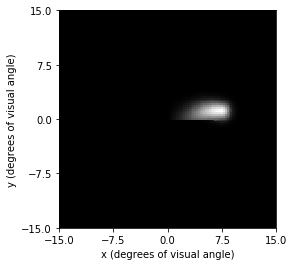

In [17]:
start = time.time()
percept = model.predict_percept(implant)
print((time.time() - start)*1000)
percept.plot()

8641.040802001953


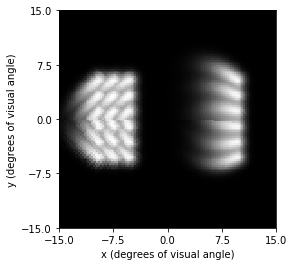

In [6]:
start = time.time()
p1 = model_orig.predict_percept(implant)
print((time.time() - start)*1000)
p1.plot()

## Timing

In [47]:
from copy import deepcopy
import time
import random
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
# Cant use same approach as above because jax isnt freeing gpu memory
def get_stim(n_elec, implant):
    elecs = random.sample(implant.electrodes.keys(), n_elec)
    stim_dict = {elec:BiphasicPulseTrain(random.randrange(10, 50, 5), 1, 0.45) for elec in elecs}
    return Stimulus(stim_dict)


442.6143169403076


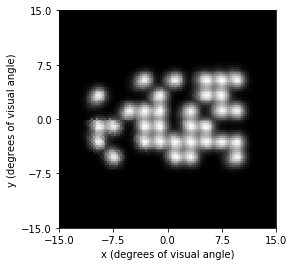

In [81]:

# implant.stim = get_stim(33, implant)
start = time.time()
p = model.predict_percept(implant)
end = time.time()
print((end - start) * 1000)
p.plot()

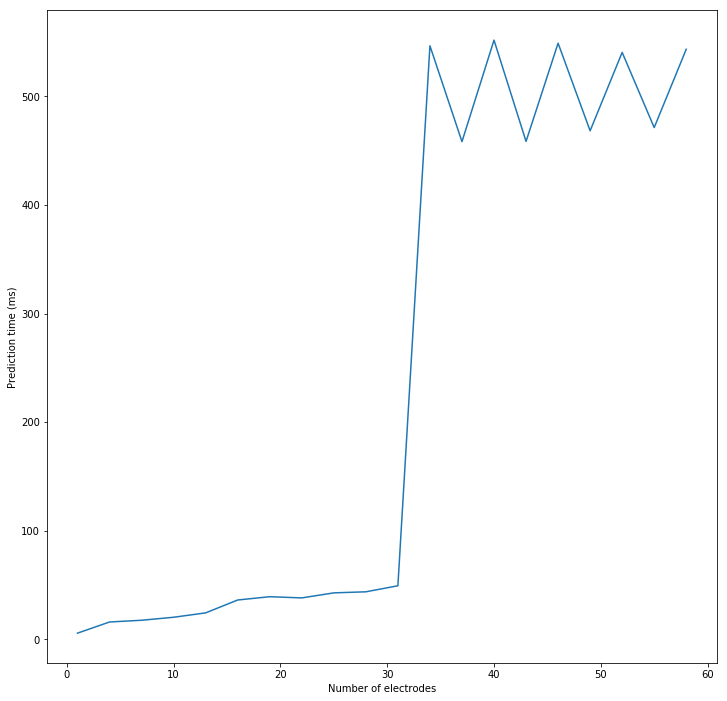

In [83]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
model = AxonMapGPU(axon_length=0.5)
model.build()
times = []
for n_elec in np.arange(1, 60, 3):
    implant.stim = get_stim(n_elec, implant)
    model.predict_percept(implant)
    start = time.time()
    p = model.predict_percept(implant)
    end = time.time()
    times.append((end - start) * 1000)

plt.plot(np.arange(1, 60, 3), times)
plt.xlabel("Number of electrodes")
plt.ylabel("Prediction time (ms)")
plt.show()

## OLD

In [2]:
# numpy copy

def gpu_biphasic_axon_map(amps, freqs, pdurs, x, y, # Per ACTIVE electrode
                          axon_segments,
                          rho, axlambda, thresh_percept, timesteps):
  deg2rad = 3.14159265358979323846 / 180.0

  n_space = len(axon_segments)

  min_size = 10**2 / rho**2
  min_streak = 10**2 / axlambda **2

  # First get contributions from F, G, H per electrode
  scaled_amps = amps / (0.8825 + 0.27*pdurs)
  brights = 1.84*scaled_amps + 0.2*freqs + 2.0986
  sizes = np.maximum(1.081*scaled_amps - 0.3533764, min_size)
  streaks = np.maximum(1.56 - 0.54 * pdurs ** 0.21, min_streak)

  I = np.zeros(shape=(n_space), dtype=np.float32)

  for idx_space in range(n_space):
    # (n_segments, n_elecs)
    d2_el = ((axon_segments[idx_space, :, 0])[:, None] - x[None, :])**2. + ((axon_segments[idx_space, :, 1])[:, None] - y[None, :])**2. 

    # (n_segments, n_elecs)
    electrode_intensities = brights * np.exp(-d2_el / ( 2. * rho**2. * sizes)) * ((axon_segments[idx_space, :, 2])[:, None] ** (1. / streaks)[None, :])
    #                      (n_elec) * (n_segments, n_elecs)                  * (n_segments, n_elecs)

    # (n_segments)
    axon_intensities = np.sum(electrode_intensities, axis=1) # ith row is intensity at ith axon segment

    axon_intensities[axon_intensities < thresh_percept] = 0.0

    I[idx_space] = np.max(axon_intensities)

  return np.asarray(np.transpose(np.tile(I, (timesteps, 1))))

In [ ]:
#OLD jax copy
"""
Function to be JIT'ed. 
Must be purely functional, and follow all rules at https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html

"""
def gpu_biphasic_axon_map(amps, freqs, pdurs, x, y, # Per ACTIVE electrode
                          axon_segments, rho, axlambda, thresh_percept, timesteps):
  deg2rad = 3.14159265358979323846 / 180.0

  n_space = len(axon_segments)

  min_size = 10**2 / rho**2
  min_streak = 10**2 / axlambda **2

  # First get contributions from F, G, H per electrode
  scaled_amps = amps / (0.8825 + 0.27*pdurs)
  brights = 1.84*scaled_amps + 0.2*freqs + 2.0986
  sizes = np.maximum(1.081*scaled_amps - 0.3533764, min_size)
  streaks = np.maximum(1.56 - 0.54 * pdurs ** 0.21, min_streak)

  I = np.zeros(shape=(n_space), dtype=np.float32)

  for idx_space in range(n_space):
    # (n_segments, n_elecs)
    d2_el = ((axon_segments[idx_space, :, 0])[:, None] - x[None, :])**2. + ((axon_segments[idx_space, :, 1])[:, None] - y[None, :])**2. 

    # (n_segments, n_elecs)
    electrode_intensities = brights * np.exp(-d2_el / ( 2. * rho**2. * sizes)) * ((axon_segments[idx_space, :, 2])[:, None] ** (1. / streaks)[None, :])
    #                      (n_elec) * (n_segments, n_elecs)                  * (n_segments, n_elecs)

    # (n_segments)
    axon_intensities = np.sum(electrode_intensities, axis=1) # ith row is intensity at ith axon segment

    # axon_intensities = jax.ops.index_update(axon_intensities, (axon_intensities < thresh_percept), 0.0)

    I = jax.ops.index_update(I, idx_space, np.max(axon_intensities))
#     I[idx_space] = np.max(axon_intensities)

  return np.asarray(np.transpose(np.tile(I, (timesteps, 1))))
